In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import os
import re

# for bessel functions and curve fitting
from scipy.optimize import curve_fit
from scipy import special

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # must be installed on your system
    "mathtext.fontset": "cm",             # Computer Modern math, matches LaTeX style
    "text.usetex": True,                    # render text via LaTeX
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}"
})

In [ ]:
def clean_inline_data(df):
    # rename columns to identical names from LEB setups
    df = df.rename(columns={'VIN': 'Vin', '-Ch1 IIN': 'Iin', '-Ch1 IOUT': 'Iout', '-Ch2 VINS': 'VinS', '-Ch3 VOUTS -Ch4': 'VoutS'})

    # iterate over all cells to manully remove and handle units + add leading 0
    for col in df.columns:
        for index, val in enumerate(df[col]):
            # scaling factor per row
            multiplier = 1.0
            if 'mA' in val:
                multiplier = 1e-3
            elif 'uA' in val:
                multiplier = 1e-6

            # remove units 
            clean_val = val.replace('V', '').replace('mA', '').replace('uA', '').replace(' ', '')
            # convert unit if needed (mA / uA)
            # df[col][index] = float(clean_val) * multiplier
            df.loc[index, col] = float(clean_val) * multiplier
    # convert to float
    df = df.apply(pd.to_numeric, errors='coerce')

    df['delta_V'] = df['VinS'] - df['VoutS']
    return df

In [ ]:
# folder_path = r"C:\Users\Lutz_Laptop\Documents\Seafile\Master\Data\TLM\CTLM Messdaten\cTLM_Ni_final"
# folder_path = r"H:\Seafile\Master\Data\TLM\CTLM Messdaten\cTLM_Ni_final"
folder_path = r"../Data/cTLM_Ni_final"

structure_data = {}

for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        list_of_measurements = {}
            
        # get r_inner from folder name => is equal in all subfolders
        match = re.search(r"\[ri=(\d+)\]", subfolder_path)
        if match:
            r_inner = int(match.group(1))   # or float(...)
            print(r_inner)
        else:
            raise ValueError("No r_inner found")    
        
        # iterate over all files in the folder
        for file in os.listdir(subfolder_path):
            if file.endswith('.roh'):
                try:
                    data = pd.read_csv(os.path.join(subfolder_path, file), delimiter=r'\s{2,}', skiprows=24, encoding='ISO-8859-1', engine='python')
                    data = clean_inline_data(data)
                    
                    limit = 0.1  # 100mA
                    # Keep only rows where compliance limit is not reached
                    data = data[data['Iin'].abs() < limit].reset_index(drop=True)

                    list_of_measurements[int(os.path.splitext(os.path.basename(file))[0])] = data
                    
                except Exception as e:
                    print(f"Error reading file {file}: {e}")
                    continue
        
        # get name of structure from subfolder
        match = re.search(r"\[description=(.*?)\]", subfolder)
        if match:
            structure_name = match.group(1)
            print(structure_name)
        else: 
            structure_name = subfolder
        structure_data[structure_name] = dict(sorted(list_of_measurements.items()))

print(structure_data.keys()) 

150
links-oben
150
links-unten
150
Mitte
150
Oben
150
recht_oben
150
Unten
dict_keys(['links-oben', 'links-unten', 'Mitte', 'Oben', 'recht_oben', 'Unten'])


In [ ]:
print(structure_data['Mitte'].keys())
print(structure_data['Mitte'][40].head())


dict_keys([40, 50, 60, 70, 80, 90, 100, 160, 240, 320, 400, 480])
    Vin      Iin     Iout   VinS  VoutS  delta_V
0 -0.12 -0.09665  0.09666 -0.060 -0.032   -0.028
1 -0.11 -0.08857  0.08858 -0.055 -0.030   -0.025
2 -0.10 -0.08049  0.08052 -0.050 -0.027   -0.023
3 -0.09 -0.07242  0.07242 -0.045 -0.024   -0.021
4 -0.08 -0.06432  0.06436 -0.040 -0.021   -0.019


In [ ]:
def get_resistance(list_of_measurements):
    R_list = []
    for key in list_of_measurements.keys():
        slope, intercept = np.polyfit(list_of_measurements[key]['delta_V'], list_of_measurements[key]['Iin'], 1)
        R_list.append((1/slope))  # in ohm

    return R_list

$$ R_{T, \text { circ }}=\frac{R_{s h}}{2 \pi}\left[\ln \left(\frac{r_i+s}{r_i}\right)+\frac{L_t}{r_i} \frac{I_0\left(\frac{r_i}{L_t}\right)}{I_1\left(\frac{r_i}{L_t}\right)}+\frac{L_t}{r_i+s} \frac{K_0\left(\frac{r_i+s}{L_t}\right)}{K_1\left(\frac{r_i+s}{L_t}\right)}\right]$$

In [ ]:
# @param geometries: arrays with the ditances and inner radius of the CTLM structure
# @param Rsh: sheet resistance -> initial guess
# @param Lt: transfer length -> initial guess
# this still uses the assumption of R_sh being constant under and between the contacts
def ctlm_bessel_model(geometries, Rsh, L_T):
        
        (distances, r_inner) = geometries
        # Term 1: Resistance of the semiconductor gap
        term_gap = np.log((r_inner + distances) / r_inner)
        
        # Term 2: Resistance of the inner contact (using using bessel functions I0 and I1)
        term_inner = (L_T / r_inner) * (special.i0(r_inner / L_T) / special.i1(r_inner / L_T))
        
        # Term 3: Resistance of the outer contact (using bessel functions K0 and K1)
        term_outer = (L_T / (r_inner + distances)) * (special.k0((r_inner + distances) / L_T) / special.k1((r_inner + distances) / L_T))
        
        # Total Resistance
        R_T = (Rsh / (2 * np.pi)) * (term_gap + term_inner + term_outer)

        return R_T

In [ ]:
# R_list = get_resistance(structure_data['Mitte'])



# popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), R_list, p0=p0, bounds=bounds)

# Rsh_fit, Lt_fit = popt

# rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²

# distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
# ri_smooth = np.full_like(distances_smooth, r_inner)
# Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

In [ ]:
def sci_notation_latex(x, precision=2):
    mantissa, exp = f"{x:.{precision}e}".split("e")
    return rf"{mantissa} \cdot 10^{{{int(exp)}}}"

Fitted parameters for links-oben: Rsh = 0.93 Ohm/sq, Lt = 118.45 um, rho_c = 1.30e-04 Ohm·cm²
Fitted parameters for links-unten: Rsh = 1.10 Ohm/sq, Lt = 91.98 um, rho_c = 9.29e-05 Ohm·cm²
Fitted parameters for Mitte: Rsh = 1.08 Ohm/sq, Lt = 99.69 um, rho_c = 1.07e-04 Ohm·cm²
Fitted parameters for Oben: Rsh = 1.02 Ohm/sq, Lt = 124.87 um, rho_c = 1.60e-04 Ohm·cm²
Fitted parameters for recht_oben: Rsh = 0.79 Ohm/sq, Lt = 153.98 um, rho_c = 1.88e-04 Ohm·cm²
Fitted parameters for Unten: Rsh = 1.77 Ohm/sq, Lt = 71.37 um, rho_c = 9.00e-05 Ohm·cm²


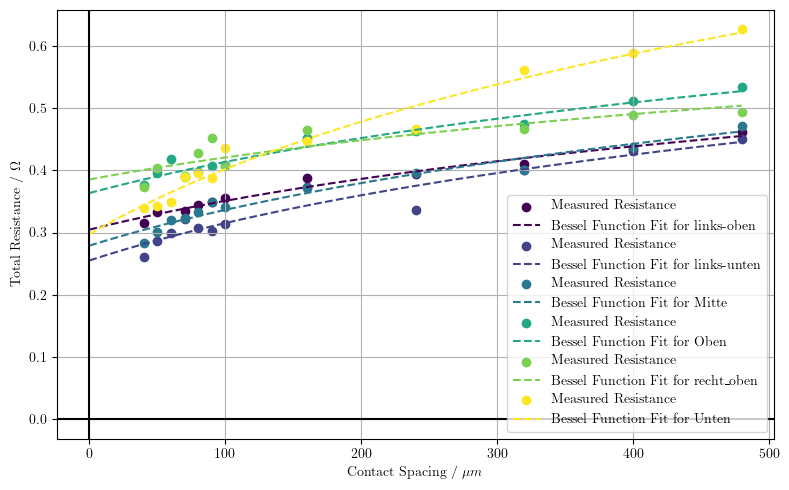

In [ ]:
# Initial Guess: [Rsh, Lt]
p0 = [1, 1]
bounds = ([0, 0], [np.inf, np.inf])

plt.figure(figsize=(8, 5))

colors = plt.get_cmap("viridis", len(structure_data))

rows = []
# for key, data in structure_data.items():
for i, (key, data) in enumerate(structure_data.items()):
    # get resistance values
    R_list = get_resistance(data)

    # get distances and r_i arrays => can be differnt, when measuremnts did not work for some distances
    distances = list(map(int,structure_data[key].keys()))
    distances = np.array(distances)
    r_inner_array = np.full_like(distances, r_inner)

    for dist, res in zip(distances, R_list):
        rows.append({
            'Structure': key,
            'Distance': dist,
            'Resistance': res
        })
    
    # fit data
    popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), R_list, p0=p0, bounds=bounds)
    Rsh_fit, Lt_fit = popt

    rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²
    print(f"Fitted parameters for {key}: Rsh = {Rsh_fit:.2f} Ohm/sq, Lt = {Lt_fit:.2f} um, rho_c = {rho_c_fit:.2e} Ohm·cm²")

    distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
    ri_smooth = np.full_like(distances_smooth, r_inner)
    Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

    plt.scatter(distances, R_list, color=colors(i), marker='o', label='Measured Resistance')
    plt.plot(distances_smooth, Rt_fit_curve, color=colors(i), linestyle='--', label=f'Bessel Function Fit for {key}')



results_df = pd.DataFrame(rows)


plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

In [ ]:
pivot_results = results_df.pivot(
    index="Structure",
    columns="Distance",
    values="Resistance"
)
print(pivot_results)

distances = pivot_results.columns.to_list()
r_inner_array = np.full_like(distances, r_inner)
print(distances)

Distance          40        50        60        70        80        90   \
Structure                                                                 
Mitte        0.283145  0.301506  0.319759  0.322661  0.333174  0.349679   
Oben         0.376557  0.396114  0.417802  0.388994  0.397094  0.406953   
Unten        0.339497  0.343416  0.348373  0.389521  0.394966  0.387768   
links-oben   0.314789  0.333422       NaN  0.334490  0.343886  0.348508   
links-unten  0.260031  0.286321  0.299103  0.321212  0.307987  0.302215   
recht_oben   0.373162  0.404202       NaN  0.390253  0.428132  0.451838   

Distance          100       160       240       320       400       480  
Structure                                                                
Mitte        0.341652  0.371030  0.395766  0.400796  0.438300  0.471299  
Oben         0.409138  0.451479  0.463019  0.474489  0.511329  0.533394  
Unten        0.435167  0.447634  0.466079  0.561704  0.588173  0.626500  
links-oben   0.355689  0.3877

### plot cTLM using median resistance values

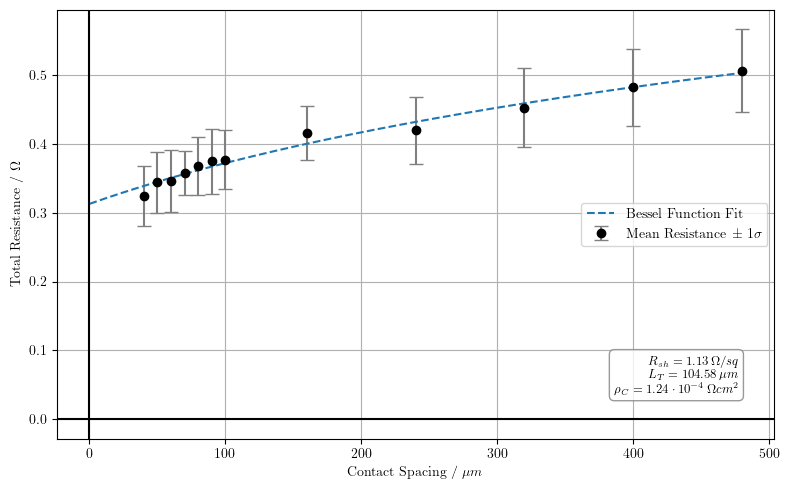

In [ ]:
plt.figure(figsize=(8, 5))

means = pivot_results.mean(axis=0)
stds = pivot_results.std(axis=0, ddof=0)    # ddof=0 uses only non nan values for the sample size in the std calculation


plt.errorbar(distances, means, yerr=stds, fmt='o', color='black', 
            ecolor='gray', capsize=5, label='Mean Resistance ± 1$\\sigma$')


# fit data using the mean resistances
popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), means, p0=p0, bounds=bounds)
Rsh_fit, Lt_fit = popt
rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²

distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
ri_smooth = np.full_like(distances_smooth, r_inner)
Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

plt.plot(distances_smooth, Rt_fit_curve, linestyle='--', label=f'Bessel Function Fit')


tlm_text = (
    f"$R_{{sh}} = {Rsh_fit:.2f} \\, \\Omega / sq$\n"
    f"$L_T = {Lt_fit:.2f} \\, \\mu m$\n"
    f"$\\rho_C = {sci_notation_latex(rho_c_fit)} \\, \\Omega cm^2$"
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
plt.grid(True)
# plt.savefig(f'../Images/{name}_bessel.pdf', dpi=500)
plt.show()

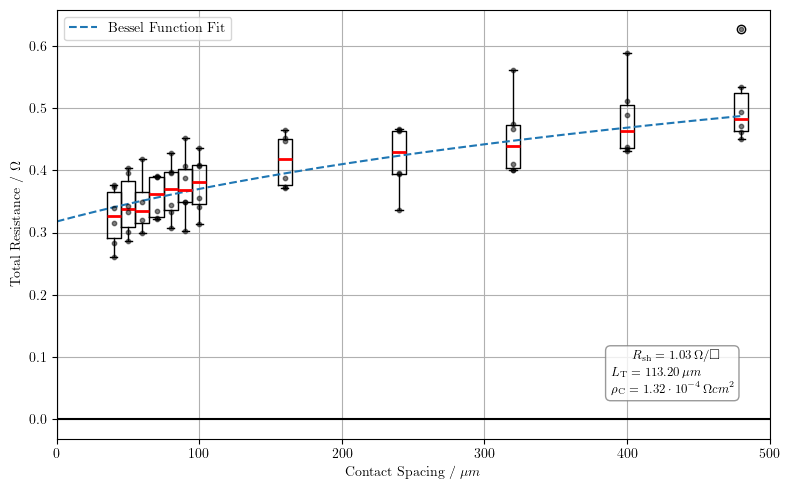

In [ ]:
# print(combined_R)
# plt.figure(figsize=(8, 5))
plt.figure()

# if NaN values exist this removes them => all boxes are plotted, even if a datapoint is missing for a distance
data_to_plot = [pivot_results[col].dropna().values for col in pivot_results.columns]
plt.boxplot(data_to_plot, positions=distances,    
            widths=10,
            # patch_artist=True,
            # boxprops=dict(facecolor='lightgray', color='black'),
            medianprops=dict(color='red', linewidth=2))

# plot actual data points
for i, distance in enumerate(distances):
    # y_values = pivot_results[distance].values
    y_values = data_to_plot[i]
    distance_list = np.full_like(y_values, distance)
    plt.scatter(distance_list, y_values, color='black', zorder=3, s=10, alpha=0.5)

medians = pivot_results.median(axis=0)

# fit data using the mean resistances
r_inner_array = np.full_like(distances, r_inner)
popt, pcov = curve_fit(ctlm_bessel_model, (distances, r_inner_array), medians, p0=p0, bounds=bounds)
Rsh_fit, Lt_fit = popt
rho_c_fit = Rsh_fit * (Lt_fit**2) * 1e-8  # 1e-8 to convert from ohm·μm² to ohm·cm²

distances_smooth = np.linspace(0, max(distances), 300) # min(distances)
ri_smooth = np.full_like(distances_smooth, r_inner)
Rt_fit_curve = ctlm_bessel_model((distances_smooth, ri_smooth), Rsh_fit, Lt_fit)

plt.plot(distances_smooth, Rt_fit_curve, linestyle='--', label=f'Bessel Function Fit')


tlm_text = (
    f"$R_{{\\mathrm{{sh}}}} = {Rsh_fit:.2f} \\, \\Omega / \\square \\\\$"
    f"$L_{{\\mathrm{{T}}}} = {Lt_fit:.2f} \\, \\mu m \\\\$"
    f"$\\rho_{{\\mathrm{{C}}}} = {sci_notation_latex(rho_c_fit)} \\, \\Omega cm^2$"
)

plt.gca().text(
    0.95, 0.1, tlm_text,
    fontsize=9,
    transform=plt.gca().transAxes,
    verticalalignment='bottom',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray')
)

import matplotlib.ticker as ticker
plt.xlim(0, 500)
plt.xticks(np.arange(0, 501, 100)) # This defines WHERE the ticks are
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

plt.xlabel("Contact Spacing / $\\mu m$")
plt.ylabel("Total Resistance / $\\Omega$")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.savefig('../Images/cTLM_Ni_Box.pdf', dpi=500)
# # plt.show()